mkidarray02_chosen_one_di_and_s_versus_temperature

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from glob import glob

from thesis.constants import Delta as Delta_fiducial, f_1p, f_mc, T_bath
from scipy.constants import h, k as k_B, pi
from scipy.special import i0, k0

In [2]:
save_directory = '/home/flanigan/temp/'
save_all_bath_temperature_response = False
thesis_directory = '/home/flanigan/thesis/'
save = True

In [3]:
temperature_key = 'temperature_package_ruox4550_temperature'
pkl_filenames = glob('2017-??-??_??????_mmw.npd.pkl')
all_data = pd.concat([pd.read_pickle(f) for f in pkl_filenames], ignore_index=True)
all_data.sort_values(by=temperature_key, inplace=True)
all_data.shape

(224, 91)

In [4]:
T_min = all_data[temperature_key].min()
T_min

0.15887709999999999

In [5]:
T_max = all_data[temperature_key].max()
T_max

0.26570860000000002

In [6]:
T_array_size = 1000
T_mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=T_min, vmax=T_max), cmap=plt.cm.coolwarm)
T_mappable.set_array(np.linspace(T_min, T_max, T_array_size))

In [7]:
s_color = 'C3'
i_color = 'C0'

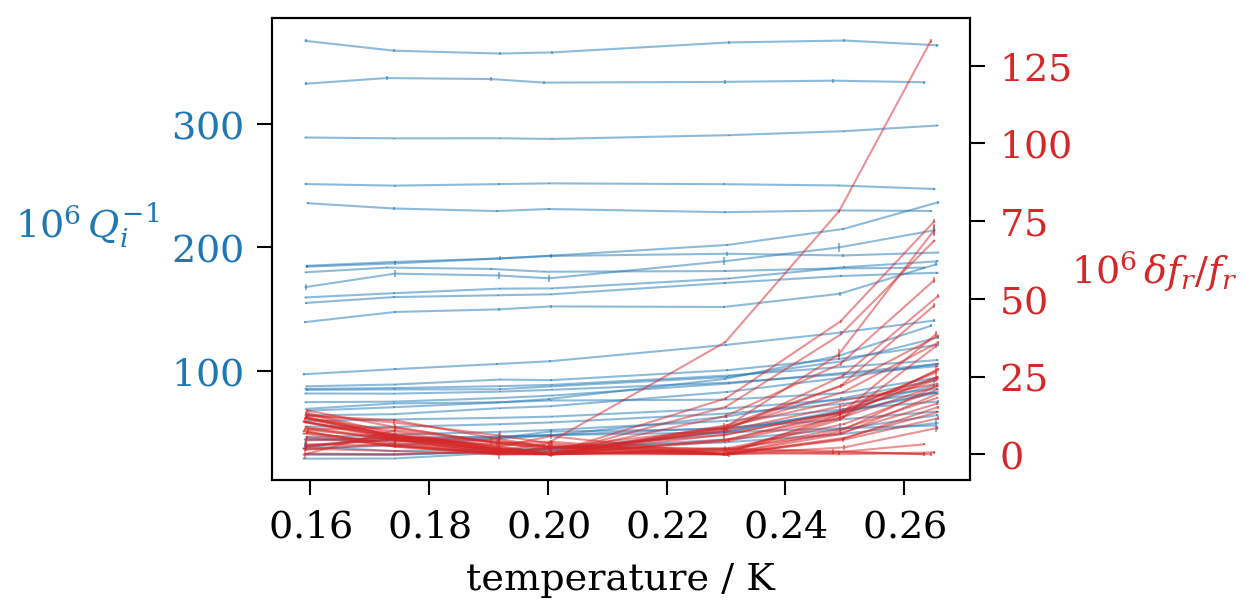

In [8]:
fig, i_ax = plt.subplots()
s_ax = i_ax.twinx()
i_ax.set_xlabel('temperature / K')
i_ax.set_ylabel('$10^6 \, Q_i^{-1}$', color=i_color, rotation='horizontal', labelpad=20)
s_ax.set_ylabel('$10^6 \, \delta f_r / f_r$', color=s_color, rotation='horizontal', labelpad=20)
i_ax.tick_params(axis='y', labelcolor=i_color)
s_ax.tick_params(axis='y', labelcolor=s_color)

df = all_data
for band_index, band_group in df.groupby('band_index'):
    for number, number_group in band_group.groupby('number'):
        temperature = number_group[temperature_key]
        s = number_group.res_f_0.max() / number_group.res_f_0 - 1
        s_error = number_group.res_f_0_error / number_group.res_f_0
        i_ax.errorbar(temperature,
                      1e6 * number_group.res_loss_i,
                      yerr=1e6 * number_group.res_loss_i_error,
                      marker=None, linestyle='-', color=i_color, alpha=0.5)
        s_ax.errorbar(temperature,
                      1e6 * s,
                      yerr=1e6 * s_error,
                      marker=None, linestyle='-', color=s_color, alpha=0.5)
#i_ax.set_ylim(-50, 500)
#s_ax.set_ylim(-5, 25);

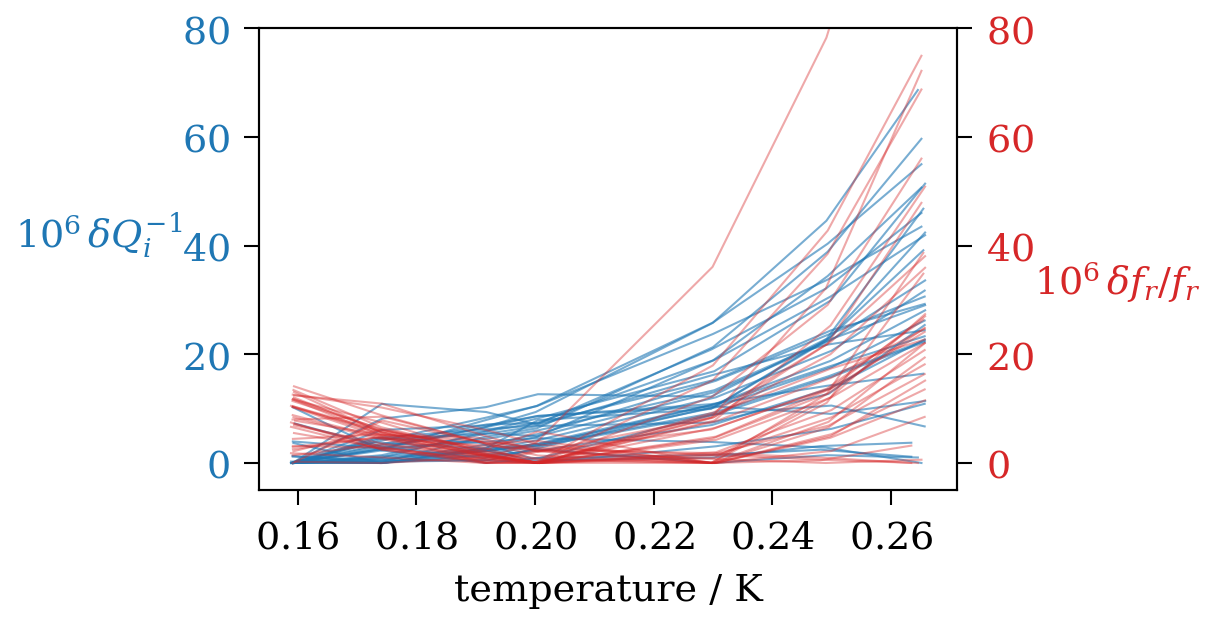

In [9]:
fig, i_ax = plt.subplots()
s_ax = i_ax.twinx()
i_ax.set_xlabel('temperature / K')
i_ax.set_ylabel('$10^6 \, \delta Q_i^{-1}$', color=i_color, rotation='horizontal', labelpad=20)
s_ax.set_ylabel('$10^6 \, \delta f_r / f_r$', color=s_color, rotation='horizontal', labelpad=20)
i_ax.tick_params(axis='y', labelcolor=i_color)
s_ax.tick_params(axis='y', labelcolor=s_color)

df = all_data
for band_index, band_group in df.groupby('band_index'):
    for number, number_group in band_group.groupby('number'):
        temperature = number_group[temperature_key]
        s = number_group.res_f_0.max() / number_group.res_f_0 - 1
        s_error = number_group.res_f_0_error / number_group.res_f_0
        di = number_group.res_loss_i - number_group.res_loss_i.min()
        di_error = number_group.res_loss_i_error
        i_ax.plot(temperature,
                      1e6 * di,
                      marker=None, linestyle='-', color=i_color, alpha=0.6)
        s_ax.plot(temperature,
                      1e6 * s,
                      marker=None, linestyle='-', color=s_color, alpha=0.4)
i_ax.set_ylim(-5, 80)
s_ax.set_ylim(-5, 80)

if save_all_bath_temperature_response:
    fig.savefig(save_directory + 'all_bath_temperature_response.pdf')

In [10]:
sorted(1e-6 * all_data[all_data.res_Q_i > 2.8e4].res_f_0)

[2778.7235997387565,
 2778.7257708165566,
 2778.7280521045923,
 2778.72861037698,
 2792.4765351378433,
 2792.4881710362797,
 2792.4941704510748,
 3122.2283572142833,
 3347.2825191681013,
 3347.300756493182,
 3347.312516997525]

# Chosen one

In [11]:
chosen = all_data[(all_data.band_index==7) & (all_data.number==3)]
chosen.shape

(7, 91)

In [12]:
TT = np.linspace(0.15, 0.27, 1000)
f_0 = chosen.res_f_0.mean()
1e-6 * f_0

3409.7320168690217

In [13]:
temperature = np.array(chosen[temperature_key])
s = np.array(chosen.res_f_0.max() / chosen.res_f_0 - 1)
s_error = np.array(chosen.res_f_0_error / chosen.res_f_0)
di = np.array(chosen.res_loss_i - chosen.res_loss_i.min())
di_error = np.array(chosen.res_loss_i_error)

In [14]:
def K_1_thermal(Delta, T, f): # notmalized
    xi = h * f / (2 * k_B * T)
    d = Delta / (k_B * T)
    return (4 / pi) * np.exp(-d) * np.sinh(xi) * k0(xi)

def K_2_thermal(Delta, T, f):
    xi = h * f / (2 * k_B * T)
    d = Delta / (k_B * T)
    return -2 * (k0(d) + np.exp(-d) * np.exp(-xi) * i0(xi))

In [17]:
import lmfit

def di_equation(T, f, Delta, alpha):
    return alpha * K_1_thermal(Delta=Delta, T=T, f=f)

def s_equation(T, f, Delta, alpha):
    return alpha / 2 * -K_2_thermal(Delta=Delta, T=T, f=f)

di_model = lmfit.Model(di_equation, independent_vars=['T', 'f'])
di_model.independent_vars

['T', 'f']

In [18]:
result = di_model.fit(di, T=temperature, f=f_0, Delta=Delta_fiducial, alpha=0.2)
Delta_fit = result.values['Delta']
alpha_fit = result.values['alpha']
print(Delta_fit / Delta_fiducial)
print(result.fit_report())

0.68421161392
[[Model]]
    Model(di_equation)
[[Fit Statistics]]
    # function evals   = 44
    # data points      = 7
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -195.197
    Bayesian info crit = -195.306
[[Variables]]
    Delta:   2.1614e-23 +/- 1.29e-24 (5.96%) (init= 3.158924e-23)
    alpha:   0.01621865 +/- 0.005951 (36.70%) (init= 0.2)
[[Correlations]] (unreported correlations are <  0.100)
    C(Delta, alpha)              =  0.998 



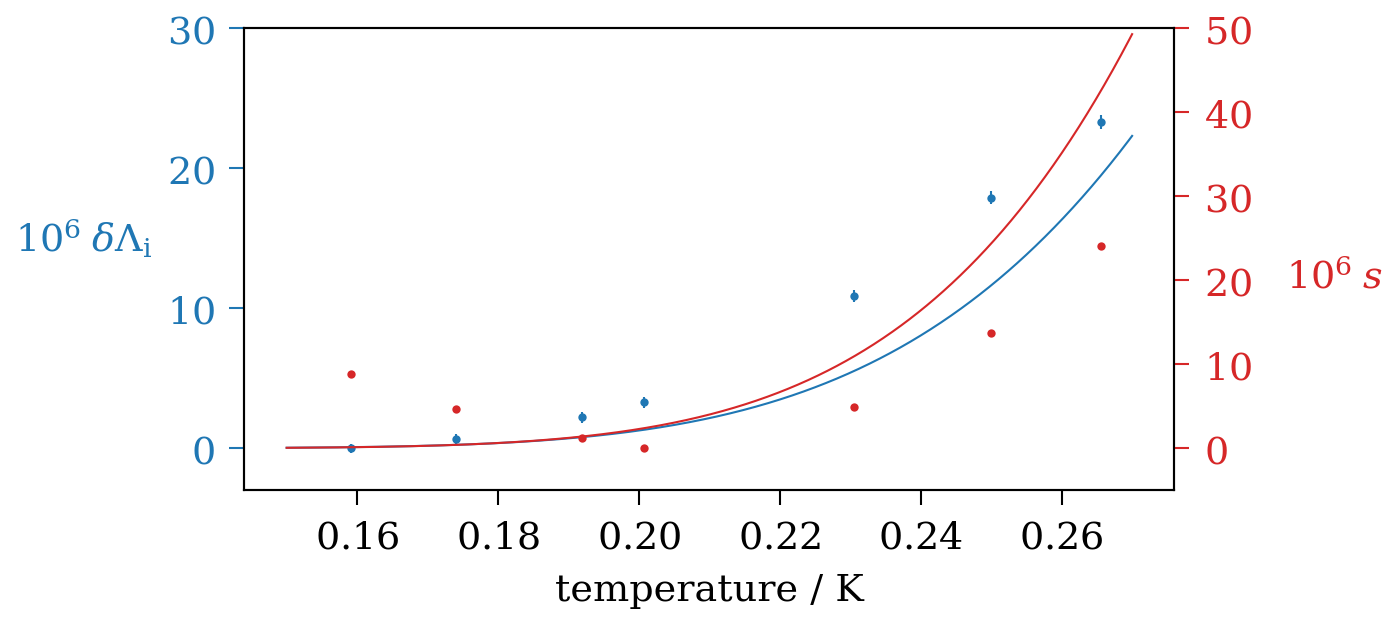

In [29]:
fig, ax_i = plt.subplots(figsize=(4, 2))
ax_s = ax_i.twinx()
ax_i.set_xlabel('temperature / K')
ax_i.set_ylabel('$10^6 \; \delta \Lambda_\mathrm{i}$', color=i_color, rotation='horizontal', labelpad=20)
ax_s.set_ylabel('$10^6 \; s$', color=s_color, rotation='horizontal', labelpad=20)
ax_i.tick_params(axis='y', labelcolor=i_color, color=i_color)
ax_s.tick_params(axis='y', labelcolor=s_color, color=s_color)


i_scale = 1e6
s_scale = 1e6
alpha=0.2
ax_i.errorbar(chosen[temperature_key], i_scale * di, yerr=i_scale * di_error,
              marker='.', markersize=4, linestyle='none', color=i_color)
ax_s.errorbar(chosen[temperature_key], s_scale * s, yerr=s_scale * s_error,
              marker='.', markersize=4, linestyle='none', color=s_color)

ax_i.plot(TT, i_scale * alpha * K_1_thermal(Delta=Delta_fiducial, T=TT, f=f_0), color=i_color)
ax_s.plot(TT, s_scale * alpha / 2 * -K_2_thermal(Delta=Delta_fiducial, T=TT, f=f_0), color=s_color)
#ax_i.plot(TT, i_scale * result.eval(T=TT), color=i_color)
#ax_s.plot(TT, s_scale * s_equation(T=TT, Delta=Delta_fit, f=f_0, alpha=alpha_fit), color=s_color)

ax_s.set_ylim(-5, 50)
ax_i.set_ylim(-3, 30)

if save:
    fig.savefig(thesis_directory + 'mkidarray02_chosen_one_di_and_s_versus_temperature.pdf')